In [23]:
import torch
from models import *
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

10


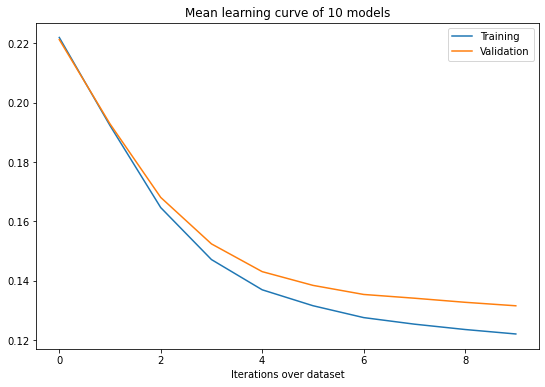

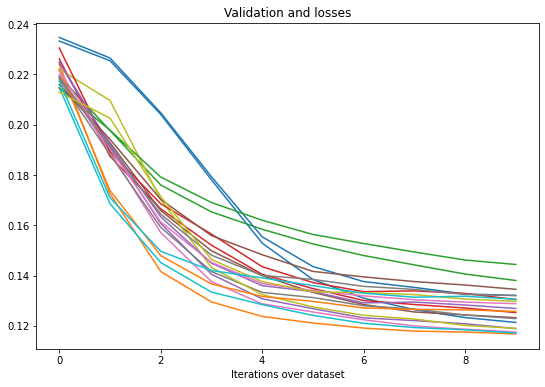

In [56]:
models_path = "trained_models/mlp_reg_baseline_5_neurons_10_epochs_test.pt"
cp = torch.load(models_path)
xval_data = cp["models_data"]
a = cp["arguments"]
print(a.epochs)
#
train_losses = torch.tensor([data["train_losses"] for data in xval_data])
validation_losses = torch.tensor([data["validation_losses"] for data in xval_data])
train_losses = torch.permute(train_losses, (1,0))
validation_losses = torch.permute(validation_losses, (1,0))

#plot mean validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses.mean(dim=1))
plt.plot(range(a.epochs), validation_losses.mean(dim=1))
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.title("Mean learning curve of 10 models")
plt.legend(["Training", "Validation"])
plt.show()

#plot the actual validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses)
plt.plot(range(a.epochs), validation_losses)
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.show()
for data in xval_data:
    train_losses = data["train_losses"]
    validation_losses = data["validation_losses"]
    model = MlpRegBaseline(neurons_per_layer=a.neurons) 
    model.load_state_dict(data["model"])
    test_X = data["test_data"]["test_X"]
    test_y = data["test_data"]["test_y"]
    test_pred_ba = torch.reshape(model(test_X), (-1,))
